In [69]:
from torch import Tensor

"""Verify if generalized f-mean of two gaussians is gaussian."""

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from pathlib import Path
from mmvae_hub.utils.fusion_functions import mixture_component_selection_embedding
from dataclasses import dataclass

[19:38:50 CEST] Log file: /Users/Hendrik/Documents/master_4/MMVAE_Hub/mmvae_hub/logger/logs/UTC-20210619-173850.log


In [54]:
BATCHSIZE = 10000
N_DIM = 2

In [55]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512, dims_out))


# a simple chain of operations is collected by ReversibleSequential
flow = Ff.SequenceINN(N_DIM)
for k in range(8):
    flow.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

Train flow to transform gaussian distr into moon distr

In [56]:
state_dict_path = Path('flow')
if state_dict_path.exists():
    flow.load_state_dict(torch.load(state_dict_path))
    moon_data, _ = make_moons(n_samples=BATCHSIZE, noise=0.05)
else:
    optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

    for i in range(1000):
        optimizer.zero_grad()
        # sample data from the moons distribution
        moon_data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
        x = torch.Tensor(moon_data)
        # pass to INN and get transformed variable z and log Jacobian determinant
        z, log_jac_det = flow(x)
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5 * torch.sum(z ** 2, 1) - log_jac_det
        loss = loss.mean() / N_DIM
        # backpropagate and update the weights
        loss.backward()
        optimizer.step()
    torch.save(flow.state_dict(), 'flow')

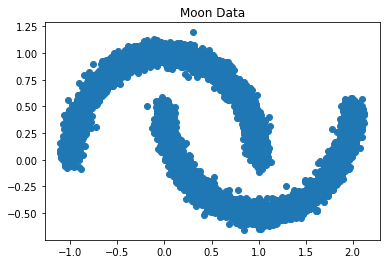

In [57]:
plt.title('Moon Data')
plt.scatter(moon_data[:, 0], moon_data[:, 1])
plt.show()

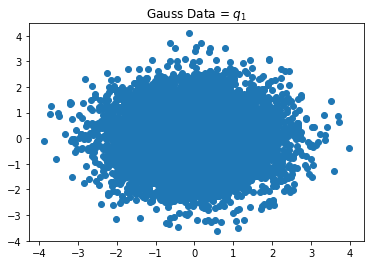

In [58]:
q1 = torch.randn(BATCHSIZE, N_DIM)
q2 = torch.randn(BATCHSIZE, N_DIM)
plt.title('Gauss Data = $q_1$')
plt.scatter(q1[:, 0], q1[:, 1])
plt.show()

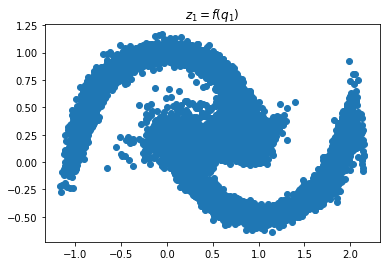

In [59]:
z1, _ = flow(q1, rev=True)
z2, _ = flow(q2, rev=True)
z1_detached = z1.detach().numpy()
plt.title('$z_1 = f(q_1)$')
plt.scatter(z1_detached[:, 0], z1_detached[:, 1])
plt.show()

In [70]:
@dataclass
class EncMod:
    zk: Tensor


@dataclass
class Args:
    device = 'cpu'
    weighted_mixture = False
    class_dim = N_DIM


args = Args()

In [72]:
z_tilde = mixture_component_selection_embedding(enc_mods={'m1': EncMod(z1), 'm2': EncMod(z2)}, s_key='m1_m2', flags=args,
                                      weight_joint=False)

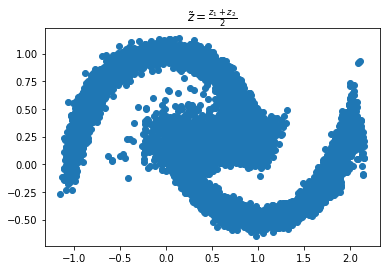

In [73]:
# z_tilde = torch.mean(torch.cat((z1.unsqueeze(dim=0), z2.unsqueeze(dim=0))), dim=0)
z_tilde_detached = z_tilde.detach().numpy()
plt.title(r'$\tilde{z} = \frac{z_1 + z_2}{2}$')
plt.scatter(z_tilde_detached[:, 0], z_tilde_detached[:, 1])
plt.show()

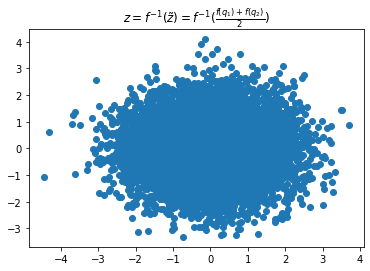

In [74]:
z, _ = flow(z_tilde)
z = z.detach().numpy()
plt.title(r'$z = f^{-1}(\tilde{z}) = f^{-1}(\frac{f(q_1) + f(q_2)}{2})$')
plt.scatter(z[:, 0], z[:, 1])
plt.show()

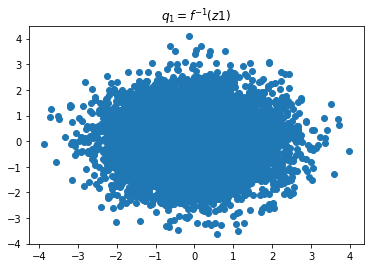

In [75]:
q1, _ = flow(z1)
q1 = q1.detach().numpy()
plt.title(r'$q_1 = f^{-1}(z1)$')
plt.scatter(q1[:, 0], q1[:, 1])
plt.show()
